<a href="https://colab.research.google.com/github/Alanjamlu34/chest-xray-pneumonia/blob/main/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip chest-xray-pneumonia.zip

In [25]:
data = Path("chest_xray")

# Set up the directories
train_dir = data / 'train'
test_dir = data / 'test'
val_dir = data / 'val'

In [26]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range = 0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [27]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Transfer Learning MobileNet

In [28]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

In [29]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_2 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3570753 (13.62 MB)
Trainable params: 1312769 (5.01 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None


In [30]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Periksa akurasi
        if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
            # Hentikan pelatihan jika batas terpenuhi
            print("\nAkurasi di atas 95%, sehingga pelatihan dihentikan!")
            self.model.stop_training = True

# Membuat instance dari kelas callback
callbacks = MyCallback()


In [31]:
EPOCHS = 10
steps = 50
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[ 'accuracy', tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps,
    callbacks = [callbacks]
)

Epoch 1/10
50/50 [==============================] - 29s 503ms/step - loss: 0.3209 - accuracy: 0.8813 - auc: 0.9312 - val_loss: 0.3799 - val_accuracy: 0.8125 - val_auc: 0.9531
Epoch 2/10
50/50 [==============================] - 23s 468ms/step - loss: 0.1389 - accuracy: 0.9506 - auc: 0.9830 - val_loss: 0.4543 - val_accuracy: 0.8125 - val_auc: 0.9531
Epoch 3/10
50/50 [==============================] - 23s 462ms/step - loss: 0.1485 - accuracy: 0.9438 - auc: 0.9809 - val_loss: 0.2129 - val_accuracy: 0.8750 - val_auc: 0.9844
Epoch 4/10
50/50 [==============================] - 23s 446ms/step - loss: 0.1249 - accuracy: 0.9519 - auc: 0.9879 - val_loss: 0.5727 - val_accuracy: 0.7500 - val_auc: 1.0000
Epoch 5/10
50/50 [==============================] - 23s 462ms/step - loss: 0.1287 - accuracy: 0.9538 - auc: 0.9851 - val_loss: 0.4994 - val_accuracy: 0.8125 - val_auc: 0.9688
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9463 - auc: 0.9849
Akurasi di atas 9

In [32]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5))

cm = confusion_matrix(true_labels, pred_labels)

test_data.class_indices

20/20 [==============================] - 9s 425ms/step


{'NORMAL': 0, 'PNEUMONIA': 1}

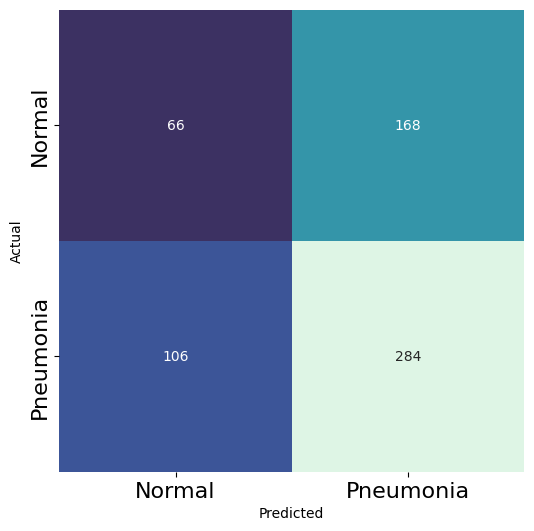

In [33]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [34]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [35]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [36]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.86
AUC: 0.94
Precision: 0.63
Recall: 0.73
